# Windspeed in Offshore Environments: 

July 2024  

Here are is an example notebook of using the ERA5 dataset for analyzing the wind conditions in offshore environments. In this notebook, the monthly mean windspeed is plotted for 2023 as an example and then the windspeed data at a single grid cell is fit with a weibull distribution. The hourly ERA5 dataset available on the cloud has an optimized chunking scheme for training machine learning models that rely on the entire lat/lon domain at each time step. This dataset is therefore not optimized for timeseries analysis.  

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from scipy.stats import weibull_min
from distributed import Client

import kwindy

In [ ]:
def calc_windspeed_time_window(ds, start_time, end_time):
    """Calculate windspeed within time window. 
    Inputs: 
        ds: Xarray Dataset containing the "100m_u_component_of_wind" and 
            "100m_v_component_of_wind" variables 
        start_time: string representing start time ('YYYY-MM-DD')
        end_time: string representing end time ('YYYY-MM-DD')
    Returns: 
        windspeed: Xarray DataArray containing windspeed within time window. 
    """
    ds_window = ds.sel(time=slice(start_time, end_time))

    windspeed = kwindy.calc_windspeed(
        ds_window["100m_u_component_of_wind"], 
        ds_window["100m_v_component_of_wind"]
    )
    windspeed = windspeed.chunk({'time':-1})
    return windspeed


def compute_weibull_parameters(windspeed, dim):
    """Fit Xarray DataArray with weibull distribution. 
    Intputs: 
        windspeed: Xarray DataArray containing windspeed data
        dim: string with name of dimension to fit along
    Returns: 
        weibull_dict: dictionary containing the parameters of 
            a weibull distribution with keys: shape, loc, and 
            scale
    """
    shape, loc, scale = kwindy.fit_weibull_xarray(windspeed, dim)

    weibull_dict = {
        'shape': shape.compute().values,
        'loc': loc.compute().values,
        'scale': scale.compute().values
    }
    return weibull_dict

In [2]:
client = Client(n_workers=8, threads_per_worker=2, ip="10.128.0.2")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.128.0.2:8787/status,
Dashboard: http://10.128.0.2:8787/status,Workers: 8
Total threads: 16,Total memory: 31.35 GiB
Status: running,Using processes: True
Comm: tcp://10.128.0.2:38885,Workers: 8
Dashboard: http://10.128.0.2:8787/status,Total threads: 16
Started: Just now,Total memory: 31.35 GiB
Comm: tcp://10.128.0.2:41067,Total threads: 2
Dashboard: http://10.128.0.2:44379/status,Memory: 3.92 GiB
Nanny: tcp://10.128.0.2:35845,


### Open full ERA5 dataset from the cloud: 
Here we open the full ERA5 dataset from 1940 to present. The hourly data is stored in a single Zarr store making managing such a large dataset manageable. The entire dataset is over 2.5 PB of data! 

In [3]:
full_era5_ds = kwindy.open_era5_from_cloud(desired_chunks={'time':'100M'})

In [31]:
full_era5_ds

<xarray.Dataset> Size: 3PB
Dimensions:                                                          (
                                                                      time: 1089864,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 9MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>

### Subsample offshore wind relevant variables: 

Next we subsample the 273 data variables available in the dataset to a subset that is relevant for offshore wind energy shown in the list below. 

In [4]:
wind_variables = [
    "100m_u_component_of_wind", 
    "100m_v_component_of_wind", 
    "2m_temperature", 
    "significant_height_of_combined_wind_waves_and_swell", 
    "sea_surface_temperature",
    'air_density_over_the_oceans'
    ]

era5_wind_ds = kwindy.subsample_era5_variables(full_era5_ds, wind_variables)

### Plot monthly mean windspeeds along US East Coast: 

In [39]:
## Subsample domain around the US East coast offshore wind development: 
era5_USeast = era5_wind_ds.sel(longitude=slice(360-76,360-70),latitude=slice(41,35))

In [40]:
## Calculate monthly mean winspeeds for a single year along the US East Coast:
windspeed_USeast = kwindy.calc_windspeed(
    era5_USeast['100m_u_component_of_wind'],
    era5_USeast['100m_v_component_of_wind'],
    )

monmn_windspeed = windspeed_USeast.sel(time=slice('2023-01-01','2023-12-31')).resample(time='ME').mean()

Working on 2023-01-31T00:00:00.000000000
Working on 2023-02-28T00:00:00.000000000
Working on 2023-03-31T00:00:00.000000000
Working on 2023-04-30T00:00:00.000000000
Working on 2023-05-31T00:00:00.000000000
Working on 2023-06-30T00:00:00.000000000
Working on 2023-07-31T00:00:00.000000000
Working on 2023-08-31T00:00:00.000000000
Working on 2023-09-30T00:00:00.000000000
Working on 2023-10-31T00:00:00.000000000
Working on 2023-11-30T00:00:00.000000000
Working on 2023-12-31T00:00:00.000000000


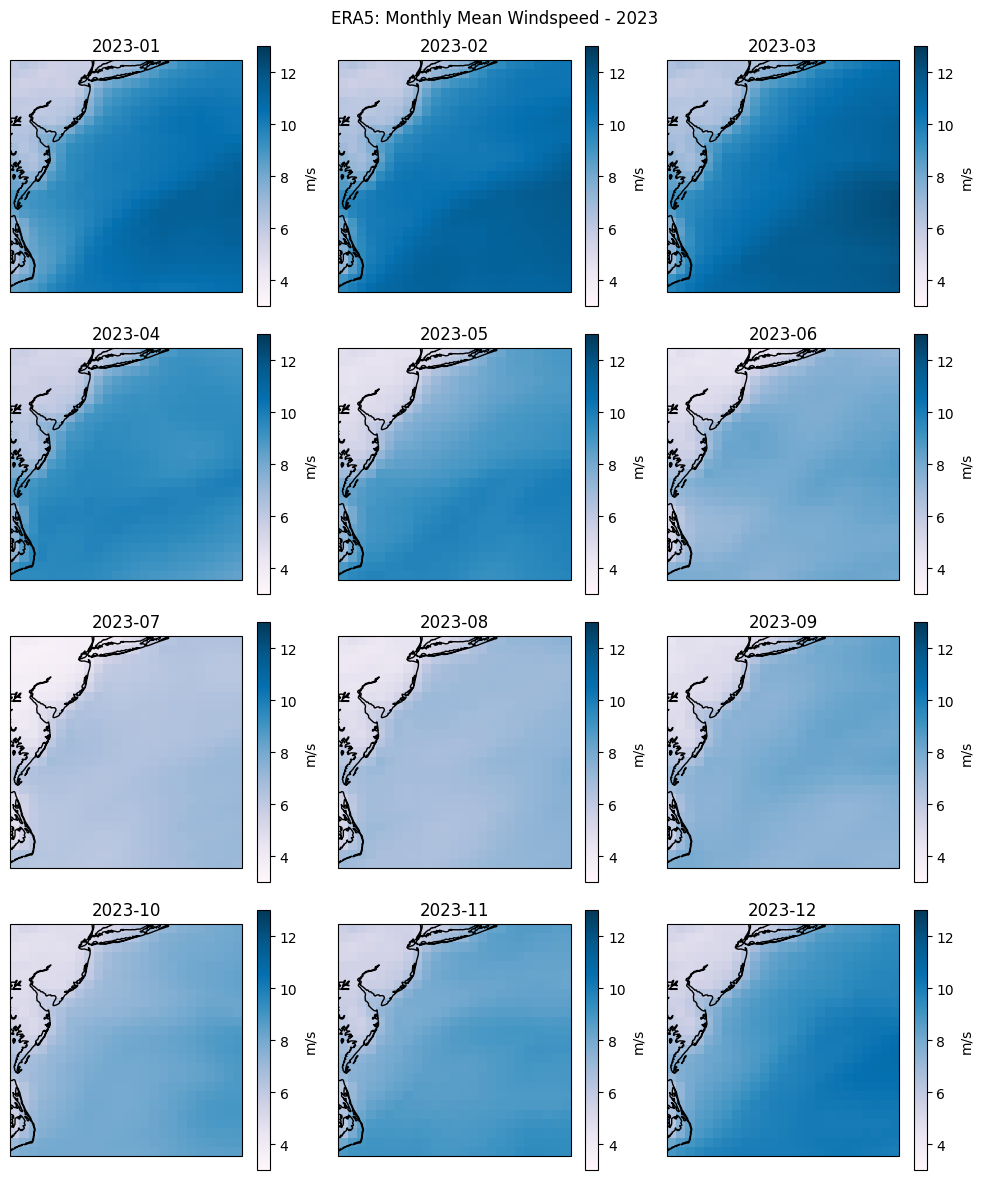

In [46]:
fig, axs = plt.subplots(4,3,figsize=(10, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax = axs.flatten()

for i, mon in enumerate(monmn_windspeed.time.values):
    print(f'Working on {mon}')
    plot = monmn_windspeed.sel(time=mon).plot(
        ax=ax[i], cmap='PuBu', vmin=3, vmax=13, add_colorbar=False
        )
    cbar = plt.colorbar(plot, ax=ax[i], label='m/s')

    ax[i].coastlines()
    ax[i].set_title(str(mon)[0:7])

plt.suptitle('ERA5: Monthly Mean Windspeed - 2023')
plt.tight_layout()

## Weibull fit for windspeed at a single point: 

Here a single grid cell is selected (shown in the map below) and a Weibull distribution is calculated for two years of hourly windspeed data. The wind energy industry generally does not account for climate change when planning wind farms given the uncertainty in projections of windspeeds and directions into the future. Further the industry generally assumes windspeed follows a Weibull distribution.  
  
Here a Weibull distribution is fit to hourly winspeed data for the years 1980 and 2023. This is done initially for a single grid cell given the size of the dataset and the relative size of the machine this analysis is being done on. To draw a conclusion this would need to be expanded to a broader domain and probe how well these Weibull distributions actually fit the data. Further, testing the statistical significance of such differences would also be necessary. One way this could be done is with a bootstrapping method.   
  
Nonetheless, we show the Weibull distribution fit for hourly data for the year 1980 and 2023 below. 

In [8]:
era5_single_point = era5_USeast.isel(latitude=10, longitude=10)

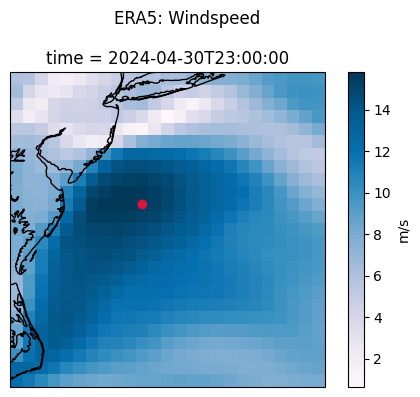

In [44]:
fig, ax = plt.subplots(figsize=(5,4), subplot_kw={'projection': ccrs.PlateCarree()})

plot = windspeed_USeast.isel(time=-1).plot(ax=ax, cmap='PuBu', add_colorbar=False)
cbar = plt.colorbar(plot, ax=ax, label='m/s')

plt.scatter(era5_single_point.longitude.values, era5_single_point.latitude.values, color='crimson')
ax.coastlines()

plt.suptitle(f'ERA5: Windspeed')
plt.tight_layout()

In [28]:
weibull_dict = {}

windspeed = calc_windspeed_time_window(era5_single_point, start_time='1980-01-01', end_time='1981-01-01')

weibull_dict['1980'] = compute_weibull_parameters(windspeed, "time")

In [32]:
windspeed = calc_windspeed_time_window(era5_single_point, start_time='2023-01-01', end_time='2024-01-01')

weibull_dict['2023'] = compute_weibull_parameters(windspeed, "time")

Text(0.5, 1.0, 'ERA5: Windspeed - Weibull Distributions')

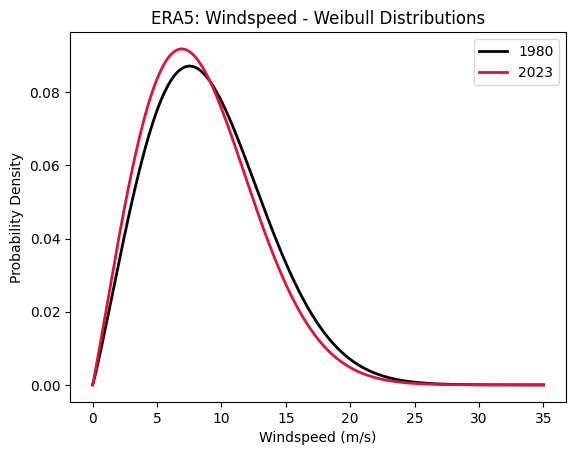

In [47]:
ws = np.linspace(0, 35, 1000)

weib_1980 = weibull_min.pdf(
    ws, weibull_dict['1980']['shape'], weibull_dict['1980']['loc'], weibull_dict['1980']['scale']
    )
weib_2024 = weibull_min.pdf(
    ws, weibull_dict['2023']['shape'], weibull_dict['2023']['loc'], weibull_dict['2023']['scale']
    )

plt.plot(ws, weib_1980, color='k',label="1980", lw=2)
plt.plot(ws, weib_2024, color='crimson',label="2023",lw=2)
plt.legend()
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Probability Density')
plt.title('ERA5: Windspeed - Weibull Distributions')